In [6]:
import os
import zipfile
from os.path import exists
from random import randrange

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import AdaBoostClassifier

from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score
from mapie.metrics import regression_mean_width_score

## 1. data preparation

In [4]:
# collect data
rent = pd.read_csv("http://www.bamlss.org/misc/rent99.raw", sep=' ')
print(rent.shape)
rent.head()

(3082, 9)


,rent,rentsqm,area,yearc,location,bath,kitchen,cheating,district
0,120.974358,3.456410,35,1939.0,1,0,0,0,1112
1,436.974335,4.201676,104,1939.0,1,1,0,1,1112
2,355.743591,12.267021,29,1971.0,2,0,0,1,2114
3,282.923096,7.254436,39,1972.0,2,0,0,1,2148
4,807.230774,8.321964,97,1985.0,1,0,0,1,2222


In [5]:
y = rent["rentsqm"]
X = rent.drop(["rent", "rentsqm", "cheating"], axis=1)

X_train, X_rest1, y_train, y_rest1 = train_test_split(X, y, train_size=1082, random_state=2)
X_test, X_rest2, y_test, y_rest2 = train_test_split(X_rest1, y_rest1, train_size=500, random_state=42)
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2, y_rest2, train_size=1000, random_state=42)

"Data sizes train: %i, test: %i, calibration: %i, new: %i" % (len(X_train), len(X_test), len(X_calib), len(X_new))

'Data sizes train: 1082, test: 500, calibration: 1000, new: 500'

## 2. train regression model

In [5]:
params = {
    "n_estimators" : [10,50,100, 500, 1000],
    "max_depth" : [None, 1, 2, 5, 10],
    "min_samples_split" : [2, 5, 10],
    "min_samples_leaf" : [1, 2, 4],
}

model = RandomForestRegressor()

# Create the random search object using 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=model, param_distributions=params, cv=5,
    n_iter=10, random_state=0)

random_search.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [4]:
random_search.best_params_

NameError: name 'random_search' is not defined

In [3]:
model = RandomForestRegressor(
    **random_search.best_params_, random_state=1)

model.fit(X_train, y_train)

NameError: name 'random_search' is not defined

In [9]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error : {: .2f}".format(mae))

Mean absolute error :  1.63


# 3. conformalize

In [10]:
mapie_reg = MapieRegressor(estimator=model, cv="prefit")
mapie_reg.fit(X_calib, y_calib)

MapieRegressor(cv='prefit',
               estimator=RandomForestRegressor(max_depth=5, min_samples_leaf=4,
                                               n_estimators=500,
                                               random_state=1),
               method='base')

In [11]:
alpha= 1/3
y_pred, y_pis = mapie_reg.predict(X_new, alpha=alpha)

In [12]:
i = randrange(len(X_new))

print(X_new.iloc[i])
print("Predicted rent_ {: .2f}".format(y_pred[i]))
interval = y_pis[i].flatten()
print("{:.1%} interval: [{:.2f}, {:.2f}]".format(1-alpha, interval[0], interval[1]))

area          74.0
yearc       1960.0
location       3.0
bath           0.0
kitchen        0.0
district     512.0
Name: 2976, dtype: float64
Predicted rent_  6.56
66.7% interval: [4.67, 8.46]


## 3.2 coverage

In [13]:
size = regression_mean_width_score(y_pis[:,0], y_pis[:,1])
print("Avg. interval size: {:.2f}".format(size))
cov = regression_coverage_score(y_new, y_pis[:,0], y_pis[:,1])
print("Coverage: {:.2f}".format(cov))

Avg. interval size: 3.79
Coverage: 0.66


# 4. Quantile regression

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

from mapie.quantile_regression import MapieQuantileRegressor

import matplotlib.pyplot as plt

# cave mapie trains lower, upper and median (although median is not realy required for calibration)

In [15]:
# !cave no hyperparameter tuning
alphas = [1/6, 5/6, 1/2]
models = []
for a in alphas:
    m = GradientBoostingRegressor(loss='quantile',alpha=a)
    m.fit(X_train, y_train)
    models.append(m)

In [16]:
i = randrange(len(X_new))-1
print("lower: {:.2f}".format(models[0].predict(X_new[i:i+1])[0]))
print("median: {:.2f}".format(models[2].predict(X_new[i:i+1])[0]))
print("higher: {:.2f}".format(models[1].predict(X_new[i:i+1])[0]))

lower: 5.84
median: 7.07
higher: 9.24


In [ ]:
cqr = MapieQuantileRegressor(models, alpha=1/3, cv="prefit")
cqr.fit(X_calib, y_calib)

# prediction
y_pred, y_qr = cqr.predict(X_new, alpha=1/3)

## 4.2 Intervall size

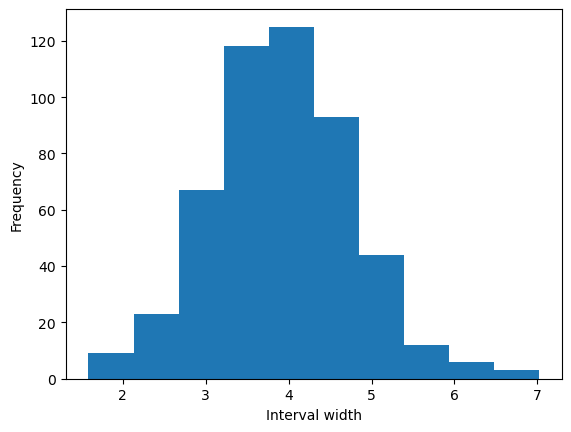

In [19]:
widths = y_qr[:,1] - y_qr[:,0]
plt.hist(widths)
plt.xlabel("Interval width")
plt.ylabel("Frequency")
plt.show()

In [33]:
from numpy.random import randint
for i in randint(0,len(X_new),5):
    print(" %.1i \t [ %.3f ; %.3f ; %.3f] \t width: %.3f" % (i, y_qr[i,0], y_pred[i], y_qr[i,1], widths[i]))

 4 	 [ 4.776 ; 6.661 ; 8.215] 	 width: 3.438
 265 	 [ 4.082 ; 6.619 ; 9.250] 	 width: 5.168
 431 	 [ 4.968 ; 6.117 ; 8.498] 	 width: 3.530
 419 	 [ 4.906 ; 7.052 ; 9.359] 	 width: 4.453
 477 	 [ 6.058 ; 7.023 ; 8.990] 	 width: 2.931


C:\Users\miche\AppData\Local\Temp\ipykernel_19140\2228625862.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(" %.1i \t [ %.3f ; %.3f ; %.3f] \t width: %.3f" % (i, y_qr[i,0], y_pred[i], y_qr[i,1], widths[i]))


## 4.3 Plot

In [40]:
def plot_quantile_by_feature(X,y,pred,qrs,feature_name):
    """
    - X (pandas DataFrame)
    - y (pandas Series)
    - pred (array-like)
    """
    xj = X[feature_name]
    order = np.argsort(xj.values)
    plt.scatter(xj,pred)
    plt.scatter(xj, y.values, color="black", alpha=1/3)
    plt.plot(xj.values[order], qrs[order][:,0], color="C1", ls="--")
    plt.plot(xj.values[order], qrs[order][:,1], color="C1", ls="--")
    
    plt.fill_between(xj.values[order].ravel(),
                     qrs[order][:,0].ravel(),
                     qrs[order][:,1].ravel(),
                     alpha=0.2,
                    )
    plt.xlabel(feature_name)
    plt.ylabel("predicted rend per sqm")

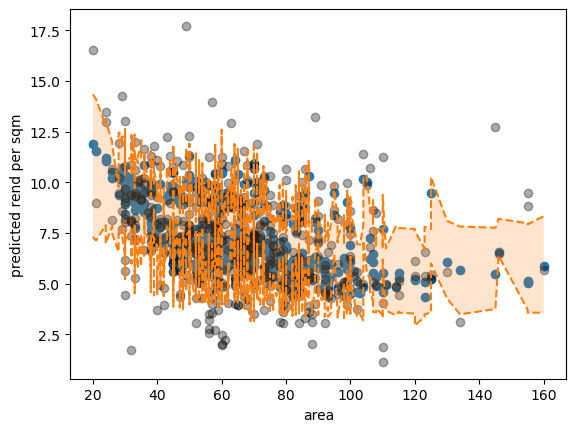

In [41]:
plot_quantile_by_feature(X_new, y_new, y_pred, y_qr, "area")

In [42]:
size = regression_mean_width_score(y_qr[:,0], y_qr[:,1])
print("Average interval width: {:.2f}".format(size))
cov = regression_coverage_score(y_new, y_qr[:,0], y_qr[:,1])
print("Coverage: {:.2%}".format(cov))

Average interval width: 3.93
Coverage: 66.60%
